In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
# Set TensorFlow logging level to suppress unnecessary logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
# Helper function to parse TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    # Decode and preprocess the image
    image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, [416, 416])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    # Extract bounding box coordinates
    xmin = parsed_example['image/object/bbox/xmin'].values
    xmax = parsed_example['image/object/bbox/xmax'].values
    ymin = parsed_example['image/object/bbox/ymin'].values
    ymax = parsed_example['image/object/bbox/ymax'].values
    
    # Select the first bounding box (if multiple exist)
    xmin = xmin[0]
    xmax = xmax[0]
    ymin = ymin[0]
    ymax = ymax[0]
    
    # Normalize bounding box coordinates relative to image size
    bbox = tf.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    return image, bbox

# Function to load dataset from TFRecord files
def load_dataset(tfrecord_file, batch_size, shuffle=False):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        parsed_dataset = parsed_dataset.shuffle(buffer_size=1000)
    
    parsed_dataset = parsed_dataset.batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

# CNN model for object detection
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(416, 416, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='sigmoid')  # Output: 4 coordinates normalized between 0 and 1
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Training function
def train_model(model, train_dataset, val_dataset, epochs=10):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )
    return history

# Function to denormalize bounding boxes
def denormalize_bbox(bbox, img_size=(416, 416)):
    height, width = img_size
    ymin, xmin, ymax, xmax = bbox
    return int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)

# Function to draw bounding boxes
def draw_bounding_boxes(image, bboxes):
    image = (image.numpy() * 255).astype(np.uint8)  # Convert back to uint8
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = denormalize_bbox(bbox)
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return image

# Function to test the model and visualize predictions
def test_and_visualize(model, test_dataset):
    for images, bboxes in test_dataset.take(5):  # Take first 5 samples for visualization
        preds = model.predict(images)
        
        for i in range(len(images)):
            image = images[i]
            pred_bbox = preds[i]
            image_with_bbox = draw_bounding_boxes(image, [pred_bbox])
            
            plt.figure(figsize=(6,6))
            plt.imshow(image_with_bbox)
            plt.axis('off')
            plt.show()

In [10]:
if __name__ == '__main__':
    # Paths to TFRecord files (use raw strings to handle backslashes)
    train_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\train\vehicles.tfrecord'
    val_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\valid\vehicles.tfrecord'
    test_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\test\vehicles.tfrecord'

    # Load datasets
    batch_size = 8
    train_dataset = load_dataset(train_tfrecord, batch_size, shuffle=True)
    val_dataset = load_dataset(val_tfrecord, batch_size)
    test_dataset = load_dataset(test_tfrecord, batch_size=1)

    # Build model
    model = build_model()


In [11]:
history = train_model(model, train_dataset, val_dataset, epochs=10)

Epoch 1/10
110/110 [==============================] - 100s 900ms/step - loss: 0.0722 - mae: 0.1996 - val_loss: 0.0543 - val_mae: 0.1698
Epoch 2/10
110/110 [==============================] - 88s 795ms/step - loss: 0.0343 - mae: 0.1383 - val_loss: 0.0581 - val_mae: 0.1741
Epoch 3/10
110/110 [==============================] - 86s 777ms/step - loss: 0.0107 - mae: 0.0758 - val_loss: 0.0502 - val_mae: 0.1622
Epoch 4/10
110/110 [==============================] - 88s 796ms/step - loss: 0.0046 - mae: 0.0494 - val_loss: 0.0516 - val_mae: 0.1686
Epoch 5/10
110/110 [==============================] - 86s 783ms/step - loss: 0.0032 - mae: 0.0396 - val_loss: 0.0527 - val_mae: 0.1680
Epoch 6/10
110/110 [==============================] - 86s 784ms/step - loss: 0.0024 - mae: 0.0349 - val_loss: 0.0511 - val_mae: 0.1652
Epoch 7/10
110/110 [==============================] - 86s 782ms/step - loss: 0.0017 - mae: 0.0287 - val_loss: 0.0514 - val_mae: 0.1655
Epoch 8/10
110/110 [==============================] - 

In [13]:
model.save('D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord')

INFO:tensorflow:Assets written to: D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\assets


INFO:tensorflow:Assets written to: D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\assets


1/1 [==============================] - 0s 93ms/step


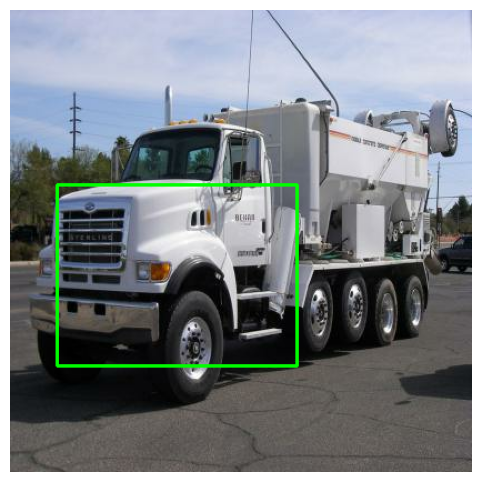

1/1 [==============================] - 0s 41ms/step


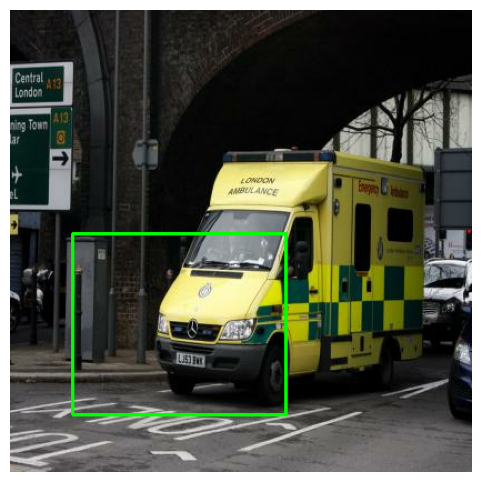

1/1 [==============================] - 0s 50ms/step


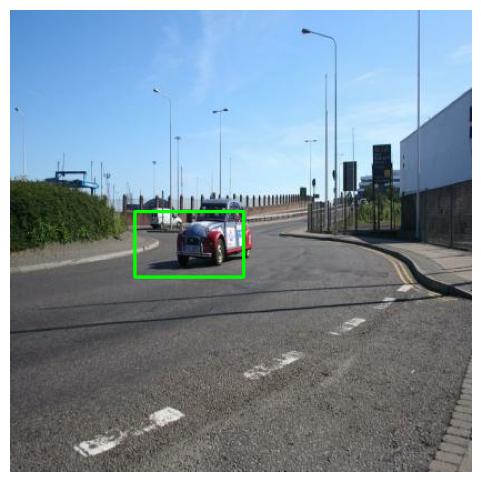

1/1 [==============================] - 0s 43ms/step


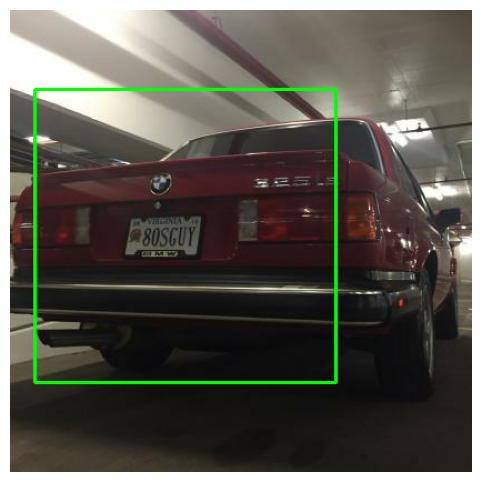

1/1 [==============================] - 0s 40ms/step


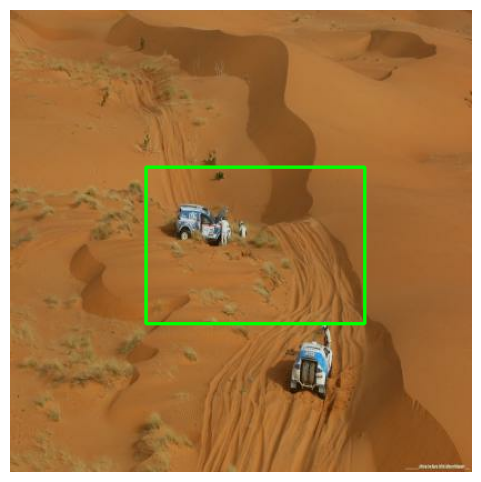

In [12]:
# Test and visualize results
test_and_visualize(model, test_dataset)

Loading Model and trying on totally unknown image

In [16]:
# Load the saved model
loaded_model = tf.keras.models.load_model(r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord')

In [17]:
# Preprocess a custom image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image to the required input size (416, 416)
    image_resized = cv2.resize(image, (416, 416))
    # Normalize the image to range [0, 1]
    image_normalized = image_resized / 255.0
    # Add batch dimension (as the model expects a batch)
    image_input = np.expand_dims(image_normalized, axis=0)
    
    return image_input, image_resized

# Function to predict and draw bounding box on the image
def predict_and_draw_bbox(model, image_input, original_image):
    # Get bounding box prediction from the model
    pred_bbox = model.predict(image_input)[0]  # Get the first result since we use batch size of 1
    
    # Denormalize the bounding box coordinates
    height, width = original_image.shape[:2]
    ymin, xmin, ymax, xmax = pred_bbox
    xmin = int(xmin * width)
    xmax = int(xmax * width)
    ymin = int(ymin * height)
    ymax = int(ymax * height)
    
    # Draw the bounding box on the image
    image_with_bbox = cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    # Display the image with bounding box
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 53ms/step


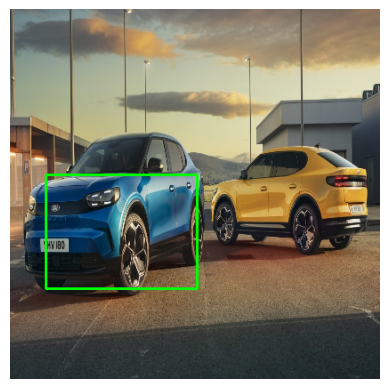

In [22]:
# Example usage
image_path = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\random_test_image_1.jpg'
image_input, original_image = preprocess_image(image_path)
predict_and_draw_bbox(loaded_model, image_input, original_image)